In [4]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments

c:\Users\larao\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [61]:
# ace data path
path = "data/raw/phee/ace/train.txt"

In [62]:
# Reading the file and creating a DataFrame
with open(path, 'r') as file:
    lines = file.readlines()

words, tags, sentence_ids = [], [], []
sentence_id = 0

for line in lines:
    if line.strip() == '':  # Check for empty line indicating end of sentence
        sentence_id += 1
    else:
        word, tag = line.strip().split()
        words.append(word)
        tags.append(tag)
        sentence_ids.append(sentence_id)

# Creating DataFrame
df = pd.DataFrame({'Sentence_ID': sentence_ids, 'Word': words, 'Org_Tag': tags})

# Print the DataFrame
print(df)


       Sentence_ID            Word           Org_Tag
0                0       OBJECTIVE                 O
1                0               :                 O
2                0              To                 O
3                0            test                 O
4                0             the                 O
...            ...             ...               ...
67090         3005               -  I-Treatment.Drug
67091         3005  aminosalicylic  I-Treatment.Drug
67092         3005            acid  I-Treatment.Drug
67093         3005         therapy       I-Treatment
67094         3005               .                 O

[67095 rows x 3 columns]


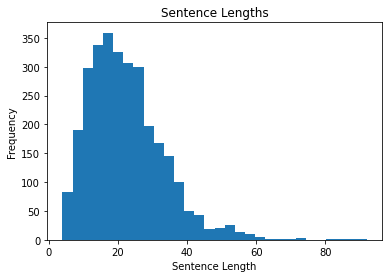

In [63]:
# calculate sentence lengths in df and plot
sentence_lengths = df.groupby('Sentence_ID').size()
sentence_lengths.plot.hist(bins=30)
plt.title('Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()




In [64]:
# max sentence length in df
max_len = sentence_lengths.max()
max_len

92

In [66]:
# Get unique tags
unique_tags = df['Org_Tag'].unique()

# Print the count of unique tags
print(f"There are {len(unique_tags)} types of tags in the dataset.")

# Print each unique tag
print("The tags are:")
for tag in unique_tags:
    print(tag)

There are 31 types of tags in the dataset.
The tags are:
O
I-Treatment.Drug
I-Adverse_event.Trigger
I-Effect
I-Treat_Disorder
I-Subject.Gender
I-Subject
I-Subject.Age
I-Treatment
I-Treatment.Treat_Disorder
I-Treatment.Route
I-Treatment.Combination.Drug
I-Combination.Drug
I-Subject.Race
I-Subject.Population
I-Subject.Sub_Disorder
I-Time_elapsed
I-Treatment.Duration
I-Treatment.Dosage
I-Potential_therapeutic_event.Trigger
I-Drug
I-Treatment.Freq
I-Treatment.Time_elapsed
I-Sub_Disorder
I-Route
I-Dosage
I-Freq
I-Duration
I-Race
I-Gender
I-Population


In [67]:
df

,Sentence_ID,Word,Org_Tag
0,0,OBJECTIVE,O
1,0,:,O
2,0,To,O
3,0,test,O
4,0,the,O
...,...,...,...
67090,3005,-,I-Treatment.Drug
67091,3005,aminosalicylic,I-Treatment.Drug
67092,3005,acid,I-Treatment.Drug
67093,3005,therapy,I-Treatment


In [68]:
unique_tags

array(['O', 'I-Treatment.Drug', 'I-Adverse_event.Trigger', 'I-Effect',
       'I-Treat_Disorder', 'I-Subject.Gender', 'I-Subject',
       'I-Subject.Age', 'I-Treatment', 'I-Treatment.Treat_Disorder',
       'I-Treatment.Route', 'I-Treatment.Combination.Drug',
       'I-Combination.Drug', 'I-Subject.Race', 'I-Subject.Population',
       'I-Subject.Sub_Disorder', 'I-Time_elapsed', 'I-Treatment.Duration',
       'I-Treatment.Dosage', 'I-Potential_therapeutic_event.Trigger',
       'I-Drug', 'I-Treatment.Freq', 'I-Treatment.Time_elapsed',
       'I-Sub_Disorder', 'I-Route', 'I-Dosage', 'I-Freq', 'I-Duration',
       'I-Race', 'I-Gender', 'I-Population'], dtype=object)

In [69]:
treatment_tags = [
    "I-Treatment.Drug",
    "I-Treatment.Combination.Drug",
    "I-Treatment",
    "I-Treatment.Route",
    "I-Treatment.Dosage",
    "I-Combination.Drug",
    "I-Treatment.Duration",
    "I-Dosage",
    "I-Freq",
    "I-Drug",
    "I-Treatment.Time_elapsed",
    "I-Treatment.Freq"
]

# Map to the new tag
treatment_mapping = {tag: "I-Treatment" for tag in treatment_tags}

In [70]:
problem_tags = [
    "I-Effect",
    "I-Treat_Disorder",
    "I-Treatment.Treat_Disorder",
    "I-Subject.Sub_Disorder",
    "I-Sub_Disorder"
]

# Map to the new tag
problem_mapping = {tag: "I-Problem" for tag in problem_tags}

In [71]:
background_tags = [
    "I-Subject.Age",
    "I-Subject.Gender",
    "I-Subject.Race",
    "I-Subject",
    "I-Race",
    "I-Gender"
]

# Map to the new tag
background_mapping = {tag: "I-Background" for tag in background_tags}

In [72]:
other_tags = [
    "I-Duration",
    "I-Time_elapsed"
]

# Map to the new tag
other_mapping = {tag: "I-Other" for tag in other_tags}


In [73]:
o_tags = [
    "I-Subject.Population",
    "I-Potential_therapeutic_event.Trigger",
    "I-Adverse_event.Trigger",
    "I-Route",
    "I-Population",
    "O"
]

# Map to the new tag
o_mapping = {tag: "O" for tag in o_tags}


In [74]:
# Combine all mappings
all_mappings = {**treatment_mapping, **problem_mapping, **background_mapping, **other_mapping, **o_mapping}

# Example usage to rename tags in a DataFrame
df["Tag"] = df["Org_Tag"].map(all_mappings)  # Map old tags to new tags
print(df)


       Sentence_ID            Word           Org_Tag          Tag
0                0       OBJECTIVE                 O            O
1                0               :                 O            O
2                0              To                 O            O
3                0            test                 O            O
4                0             the                 O            O
...            ...             ...               ...          ...
67090         3005               -  I-Treatment.Drug  I-Treatment
67091         3005  aminosalicylic  I-Treatment.Drug  I-Treatment
67092         3005            acid  I-Treatment.Drug  I-Treatment
67093         3005         therapy       I-Treatment  I-Treatment
67094         3005               .                 O            O

[67095 rows x 4 columns]


In [77]:
len(df['Tag'].unique())

5

In [19]:
model = AutoModelForTokenClassification.from_pretrained("samrawal/bert-base-uncased_clinical-ner")
tokenizer = AutoTokenizer.from_pretrained("samrawal/bert-base-uncased_clinical-ner")


Downloading: 100%|██████████| 895/895 [00:00<?, ?B/s] 
Downloading: 100%|██████████| 436M/436M [00:11<00:00, 39.3MB/s] 
Downloading: 100%|██████████| 300/300 [00:00<?, ?B/s] 
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 15.9MB/s]


In [30]:
data_path = "data/raw/phee/train.json"

In [31]:
# Convert JSON data to a DataFrame
dff = pd.read_json(data_path, lines=True)

In [32]:
dff

,id,context,is_mult_event,annotations
0,89083963,OBJECTIVE: To test the hypothesis that tumor n...,False,"[{'events': [{'event_id': 'E1', 'event_type': ..."
1,108919911,An evaluation of ovarian structure and functio...,False,"[{'events': [{'event_id': 'E1', 'event_type': ..."
2,23325961,Phenobarbital hepatotoxicity in an 8-month-old...,False,"[{'events': [{'event_id': 'E1', 'event_type': ..."
3,125520541,The authors report a case of Balint syndrome w...,True,"[{'events': [{'event_id': 'E1', 'event_type': ..."
4,1953169512,"According to the Naranjo probability scale, fl...",True,"[{'events': [{'event_id': 'E1', 'event_type': ..."
...,...,...,...,...
2893,29314453,L-T4 stimulated lymphocyte transformation in t...,False,"[{'events': [{'event_id': 'E1', 'event_type': ..."
2894,121262251,A 53-year-old man developed lower leg edema 4 ...,False,"[{'events': [{'event_id': 'E1', 'event_type': ..."
2895,31435512,A mentally retarded 23-year-old woman with myo...,False,"[{'events': [{'event_id': 'E1', 'event_type': ..."
2896,120865491,"After 5 days of treatment with IL-2, the patie...",False,"[{'events': [{'event_id': 'E1', 'event_type': ..."


In [34]:
len(dff)

2898

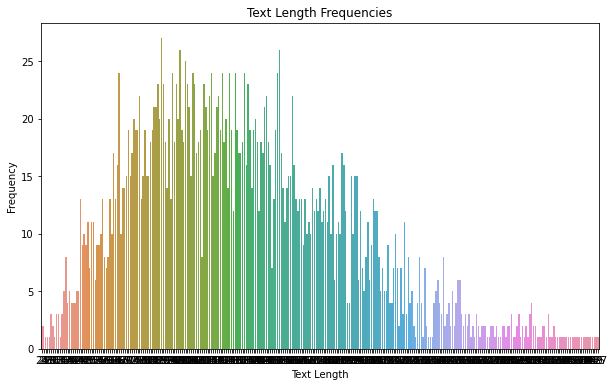

Average text length: 134.91235334713596


In [35]:
# Calculate the average text length
average_text_length = dff['context'].apply(len).mean()

# Calculate the frequency distribution of text lengths
text_lengths = dff['context'].apply(len)
text_length_counts = text_lengths.value_counts().reset_index()
text_length_counts.columns = ['Text Length', 'Frequency']

# Create a bar plot for text length frequencies
plt.figure(figsize=(10, 6))
sns.barplot(x='Text Length', y='Frequency', data=text_length_counts)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Frequencies')
plt.show()

# Display the average text length
print("Average text length:", average_text_length)


In [42]:
dff['context'][0]

'OBJECTIVE: To test the hypothesis that tumor necrosis factor (TNF)-alpha may mediate the loss and the dedifferentiation of subcutaneous fat tissue in the insulin-induced lipoatrophies of a diabetic patient who presented extensive lesions.'

In [37]:
# print the text that has the max length in df
max_text_length = dff['context'].apply(len).max()
print("Max text length:", max_text_length)
print(dff[dff['context'].apply(len) == max_text_length]['context'].iloc[0])

Max text length: 527
A 47-year-old HIV-infected man with dilated cardiomyopathy and prolonged QT syndrome with an automatic implantable cardiovascular defibrillator device was prescribed subcutaneous enfuvirtide 90 mg twice daily as part of his antiretroviral regimen and oral extended-release niacin 500 mg/day for a high-density lipoprotein level of 8 mg/dL. After 1 week of concomitant therapy, the patient began experiencing extreme redness, edema, and swelling at the injection site that corresponded with the flushing sensation due to niacin.


In [12]:
# print df['annotations'] of the max length text
print(df[df['context'].apply(len) == max_text_length]['annotations'].iloc[0])
# show it in df format
pd.DataFrame(df[df['context'].apply(len) == max_text_length]['annotations'].iloc[0])


[{'events': [{'event_id': 'E1', 'event_type': 'Adverse_event', 'Trigger': {'text': [['experiencing']], 'start': [[395]], 'entity_id': ['T20']}, 'Subject': {'text': [['A 47-year-old HIV-infected man with dilated cardiomyopathy and prolonged QT syndrome with an automatic implantable cardiovascular defibrillator device']], 'start': [[0]], 'entity_id': ['T17'], 'Disorder': {'text': [['dilated cardiomyopathy'], ['prolonged QT syndrome']], 'start': [[36], [63]], 'entity_id': ['T18', 'T1']}, 'Age': {'text': [['47-year-old']], 'start': [[2]], 'entity_id': ['T22']}, 'Gender': {'text': [['man']], 'start': [[27]], 'entity_id': ['T24']}}, 'Treatment': {'text': [['subcutaneous enfuvirtide 90 mg twice daily as part of his antiretroviral regimen and oral extended-release niacin 500 mg/day for a high-density lipoprotein level of 8 mg/dL']], 'start': [[166]], 'entity_id': ['T19'], 'Disorder': {'text': [['HIV-infected']], 'start': [[14]], 'entity_id': ['T23']}, 'Dosage': {'text': [['90 mg'], ['500 mg']]

,events
0,"[{'event_id': 'E1', 'event_type': 'Adverse_eve..."


In [7]:
# How many words are there that are longer than 512 characters? and how many are there that are longer than 256 characters?
long_text = df[df['context'].apply(len) > 512]
print("Number of long texts:", len(long_text))

# # remove long texts
# df = df[df['context'].apply(len) <= 256]

Number of long texts: 1


In [20]:
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-v1.1')

Downloading: 100%|██████████| 49.0/49.0 [00:00<00:00, 12.1kB/s]
Downloading: 100%|██████████| 462/462 [00:00<00:00, 1.74MB/s]
Downloading: 100%|██████████| 213k/213k [00:00<00:00, 13.2MB/s]
Downloading: 100%|██████████| 112/112 [00:00<?, ?B/s] 


In [25]:
def encode_data(tokenizer, text, max_length):
    encoded = tokenizer.batch_encode_plus(
        text,
        truncation=True,
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'  # return PyTorch tensors
    )
    return encoded["input_ids"], encoded["attention_mask"], encoded
# Use an appropriate max_length 
input_ids, attention_mask, encoded= encode_data(tokenizer, df['context'].tolist(), max_length=256)

In [28]:
encoded

{'input_ids': tensor([[  101,   152,  2064,  ...,     0,     0,     0],
        [  101,  1760, 10540,  ...,     0,     0,     0],
        [  101,  7642, 26601,  ...,     0,     0,     0],
        ...,
        [  101,   138, 10883,  ...,     0,     0,     0],
        [  101,  1258,   126,  ...,     0,     0,     0],
        [  101,   138, 23987,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [38]:
df['annotations'][0][0]['events']

[{'event_id': 'E1',
  'event_type': 'Adverse_event',
  'Trigger': {'text': [['induced']], 'start': [[162]], 'entity_id': ['T4']},
  'Treatment': {'text': [['insulin']],
   'start': [[154]],
   'entity_id': ['T3'],
   'Drug': {'text': [['insulin']], 'start': [[154]], 'entity_id': ['T6']},
   'Disorder': {'text': [['diabetic']],
    'start': [[189]],
    'entity_id': ['T7']}},
  'Effect': {'text': [['lipoatrophies']],
   'start': [[170]],
   'entity_id': ['T5']}}]

In [24]:
attention_mask

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [ ]:
train_args = {
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'sliding_window': True,
    'max_seq_length': 64,
    'num_train_epochs': 10,
    'train_batch_size': 32,
    'fp16': True,
    'output_dir': '/outputs/',
    'best_model_dir': '/outputs/best_model/',
    'evaluate_during_training': True,
}